# Tweet Sentiment Extraction
### Extract support phrases for sentiment labels
With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

In this competition we've extracted support phrases from Figure Eight's Data for Everyone platform. The dataset is titled Sentiment Analysis: Emotion in Text tweets with existing sentiment labels, used here under creative commons attribution 4.0. international licence. Your objective in this competition is to construct a model that can do the same - look at the labeled sentiment for a given tweet and figure out what word or phrase best supports it.

In this section we implement some of function from EDA-noutbook and made some further preprocessing data, we use spelling analysis and GLOVE for creating embedding layer for models. We experimented with a wide range on architectures and clearing functions. 

Main parts:
1. Libraries
2. Functions
3. Load data
4. Data prerocessing
    - Spellig analysis
    - Creating embeddings with GLOVE
5. Model
6. Prediction
7. Submission
Conclusion

# 1. Load libraries

In [1]:
import datetime
import collections
import string
import re
import nltk
import os
from tensorflow.keras import regularizers, optimizers
from keras.models import load_model, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate, BatchNormalization, Bidirectional
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, Model
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from tqdm import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# 2. Functions

In [2]:
def read_train():
    """
        Load train dataset
    """
    train = pd.read_csv(
        '../input/tweet-sentiment-extraction/train.csv').dropna()
    train['text'] = train['text']
    train['selected_text'] = train['selected_text']
    return train


def read_test():
    """
        Load test dataset
    """
    test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').dropna()
    test['text'] = test['text']
    return test


def clear_text(text):
    '''
        Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.
    '''
    text = str(text).strip().lower()
    text = re.sub(r'(.)1+', r'1', text)  # Removing repeating simbols
    text = re.sub('((www.[^s]+)|(https?://[^s]+))',
                  ' ', text)  # Removing Hyperinks
    text = re.sub('\S*\d\S*', ' ', text)  # Removing Numbers
    text = re.sub('<.*?>+', ' ', text)  # Removing Angular Brackets
    text = re.sub('\[.*?\]', ' ', text)  # Removing Square Brackets
    text = re.sub('\n', ' ', text)  # Removing '\n' character
    text = re.sub('\*+', '<ABUSE>', text)  # Replacing **** by ABUSE word
    # Removing punctuation
    text = "".join([i for i in text if i not in string.punctuation])
    return text


def wrong_words(text, selected):
    """
        Check two text fields and select words in selected_text 
        which not exists in text
    """
    words = []
    text = text.split()
    selected = selected.split()
    for i in selected:
        if i not in text:
            words.append(i)
    if len(words) > 0:
        return " ".join(words)
    else:
        return '++++'


def remove_text(x):
    """
        remove marked text from selected text
    """
    selected = x[0]
    spelling = x[1]
    selected = selected.split()
    selected.remove(spelling)
    return " ".join(selected)


def remove_text_end(x):
    """
        remove marked text only in the end of row
    """
    selected = x[0]
    spelling = x[1]
    selected = selected.split()
    if selected[-1] == spelling:
        selected.remove(spelling)
    return " ".join(selected)


def matching(x, tg):
    """
        Check words on similarities and take correct word from first field
    """
    text = x[0]
    selected = x[1]
    spelling = x[2]
    text = text.split()
    selected = selected.split()
    spelling = spelling.split()
    for s in spelling:
        for t in text:
            if s in selected:
                if(fuzz.ratio(t, s) > tg):
                    index = selected.index(s)
                    selected[index] = t
    return " ".join(selected)


def swap_text(x):
    """
        replace short text with longer one
    """
    text = x[0]
    selected = x[1]
    if len(selected) > len(text):
        return selected
    return text


def start_index(x):
    """
        Search position in text, where selected_text is starting.
        Return this position
    """
    text = x[0]
    selected = x[1]
    text = text.split()
    selected = selected.split()
    word = selected[0]
    index = text.index(word)
    return index


def end_index(x):
    """
        Search position in text, where selected_text is ending.
        Return this position
    """
    text = x[0]
    selected = x[1]
    start_index = x[2]
    text = text.split()
    selected = selected.split()
    word = selected[-1]
    try:
        index = text.index(word, start_index)
    except:
        index = text.index(word)
    return index


def jaccard(str1, str2):
    """
        Calculates Jaccard score
    """
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


def get_text(x):
    """
        return text by predicted index
    """
    pred = []
    text = x[0]
    index = x[1]
    text = text.split()
    l = len(text)
    for i in index:
        if i < l:
            pred.append(text[i])
    return pred

# 3. Load data

In [3]:
train = read_train()
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
test = read_test()
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


# 4. Data processing

#### Clearing text

In [5]:
train['text'] = train['text'].apply(lambda x: clear_text(x))
test['text'] = test['text'].apply(lambda x: clear_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x: clear_text(x))

##### Check lenght of text and selected text

In [6]:
train[train['text'].apply(lambda x: len(x)) <
      train['selected_text'].apply(lambda x: len(x))]

,textID,text,selected_text,sentiment
239,85ec413e54,,luv,positive
455,754ebd84b4,,me at forever ethan couldnt be there,negative
1147,8263d62bf3,s boys and poets ordering medici and white ch...,at bus boys and poets ordering medici and whit...,neutral
1277,7b9efb5c34,s the most colorful thing ive seen all daywow,thats the most colorful thing ive seen all daywow,positive
1319,bc84f21e3b,,shoesshoesshoesyayyayyayloli,positive
...,...,...,...,...
26687,c5de5361d2,does anyone out there want to be really awesom...,does anyone out there want to be really awesom...,neutral
26712,9c4c75d53b,say mystery science theatre does that mean ...,if i say mystery science theatre does that ...,neutral
26929,35f9385c07,,pretty,positive
27114,556d273874,,vote for rob,neutral


For rows, where length text less then selected_text write selected_text in text

In [7]:
train['text'] = train[['text', 'selected_text']].apply(
    lambda x: swap_text((x.text, x.selected_text)), axis=1)
train[train['text'].apply(lambda x: len(x)) <
      train['selected_text'].apply(lambda x: len(x))]

,textID,text,selected_text,sentiment


##### Removing rows with blank Text or Selected text

In [8]:
print(train[train["text"] == ' ']['text'].count())
print(train[train["selected_text"] == ' ']['selected_text'].count())

13
19


In [9]:
train.drop(train[train["text"] == ' '].index, inplace=True)
train.drop(train[train["selected_text"] == ' '].index, inplace=True)

##### Working with spelling

Lets mark all rows, where selected_text contain symbols not exists in text and count rows with correct spelling

In [10]:
train['spelling'] = train.apply(
    lambda x: wrong_words(x.text, x.selected_text), axis=1)
train[train['spelling'] == '++++'].count()

textID           25477
text             25477
selected_text    25477
sentiment        25477
spelling         25477
dtype: int64

One wrong symbol

In [11]:
train[train['spelling'].apply(lambda x: len(x)) == 1]

,textID,text,selected_text,sentiment,spelling
49,3fcea4debc,which case i got a new one last week and im no...,d im not thrilled at all with mine,negative,d
66,95e12b1cb1,hes awesome have you worked with him before he...,s awesome,positive,s
129,94f67cfa6d,hey mia totally adore your music when will y...,y adore,positive,y
134,6903cb08f2,nice to see you tweeting its may and were c...,e nice,positive,e
166,c78bf59e67,lichfield tweetup sounds like fun hope to see...,p sounds like fun,positive,p
...,...,...,...,...,...
27153,a044ed928d,enjoy nola definitely one of my favorite citie...,y one of my favorite cities in the world,positive,y
27240,40143b692e,who knows it makes me sad lol,e sad,negative,e
27426,132e051fe8,my cousins moved there like years ago and i ...,m sad,negative,m
27470,778184dff1,lol i know and hahadid you fall asleep or jus...,t bored,negative,t


and correct them

In [12]:
train['selected_text'] = train[['selected_text', 'spelling']].apply(
    lambda x: remove_text(x) if len(x['spelling']) == 1 else x['selected_text'], axis=1)
train['spelling'] = train.apply(
    lambda x: wrong_words(x.text, x.selected_text), axis=1)
train[train['spelling'] == '++++'].count()

textID           26147
text             26147
selected_text    26147
sentiment        26147
spelling         26147
dtype: int64

two symbols

In [13]:
train[train['spelling'].apply(lambda x: len(x)) == 2]

,textID,text,selected_text,sentiment,spelling
27,bdc32ea43c,on the way to malaysiano internet access to twit,no internet,negative,no
39,2863f435bd,a little happy for the wine jeje ok itsm my fr...,a little happy fo,positive,fo
48,3d9d4b0b55,i donbt like to peel prawns i also dont like g...,dont like go,negative,go
247,ce69e99e71,im not sleeping at all until accepts my appology,im not sleeping at all un,negative,un
362,b94aaf845e,please review sunehre ad placement,please re,positive,re
...,...,...,...,...,...
27044,2f31dd75de,didnt make it but i smoked her shes at an...,thank yo,positive,yo
27302,90c8aa60db,have i ever told you i absolutly hate writing ...,hate wr,negative,wr
27349,f60f20ed09,yea but thats an old pic she looks a lot diff...,yea but thats an old pic she looks a lot diff...,neutral,lo
27456,d32efe060f,i wanna leave work already not feelin it,wanna leave work al,negative,al


if that symbols situated in the end of selected text - just remove them

In [14]:
train['selected_text'] = train[['selected_text', 'spelling']].apply(
    lambda x: remove_text_end(x) if len(x['spelling']) == 2 else x['selected_text'], axis=1)
train['spelling'] = train.apply(
    lambda x: wrong_words(x.text, x.selected_text), axis=1)
train[train['spelling'] == '++++'].count()

textID           26483
text             26483
selected_text    26483
sentiment        26483
spelling         26483
dtype: int64

#### For other cases we will use library fuzzywuzzy, which allow obtain degree of matching two sentences

In [15]:
print(fuzz.ratio('geeksforgeeks', 'geeksgeeks'))
print(fuzz.ratio('GeeksforGeeks', 'GeeksforGeeks'))

87
100


first step set matching level = 70% and look at result

In [16]:
train['selected_text'] = train[['text', 'selected_text', 'spelling']].apply(
    lambda x: matching(x, 70) if x['spelling'] != '++++' else x['selected_text'], axis=1)
train['selected_text'] = train[['selected_text', 'spelling']].apply(
    lambda x: remove_text(x) if len(x['spelling']) == 1 else x['selected_text'], axis=1)
train['spelling'] = train.apply(
    lambda x: wrong_words(x.text, x.selected_text), axis=1)
train[(train['spelling'] != '++++')]

,textID,text,selected_text,sentiment,spelling
27,bdc32ea43c,on the way to malaysiano internet access to twit,no internet,negative,no
189,a0a306868a,lost my tooth whilst i was eating gumoww,oww,negative,oww
201,c017d0c221,s hit,hate,negative,hate
223,242d92151a,walking to class i hate not having a bikeespec...,i hate not having a bike,negative,bike
251,77ba0fee75,powerblog what is this powerblog challenge you...,g what is this powerblog challenge you keep ta...,neutral,g
...,...,...,...,...,...
27339,27829d441f,just got out of the pool so funnow gonna wat...,so fun,positive,fun
27362,7b82d63ee4,just found out i wont be tweeting from my phon...,c sorry,negative,c
27376,13fbc75291,going to church in the morninghappy mommas day...,happy,positive,happy
27386,e149ebd3a1,would one of the vwllers want to add this ev...,ch appreciate,positive,ch


next step - 55%

In [17]:
train['selected_text'] = train[['text', 'selected_text', 'spelling']].apply(
    lambda x: matching(x, 55) if x['spelling'] != '++++' else x['selected_text'], axis=1)
train['spelling'] = train.apply(
    lambda x: wrong_words(x.text, x.selected_text), axis=1)
train[(train['spelling'] != '++++')]

,textID,text,selected_text,sentiment,spelling
27,bdc32ea43c,on the way to malaysiano internet access to twit,no internet,negative,no
223,242d92151a,walking to class i hate not having a bikeespec...,i hate not having a bike,negative,bike
251,77ba0fee75,powerblog what is this powerblog challenge you...,g what is this powerblog challenge you keep ta...,neutral,g
349,322b61740c,degrees gross skies and thunderstormsperfect...,perfect match,positive,perfect
569,03f9f6f798,i dont think ive ever been so tierd in my life...,i dont think ive ever been so tierd in my lifeu,negative,lifeu
...,...,...,...,...,...
26886,fc9eb14f18,supernatural st,liked,positive,liked
27149,d7f89cb7a4,if you save these pix from the today show plea...,thanks,positive,thanks
27159,c22e61bf24,s great especially if lots of them help,moving s great,positive,moving
27209,30a1e8c2b4,guys i know my ability to read time telli...,es failed,negative,es


And finally - 35%

In [18]:
train['selected_text'] = train[['text', 'selected_text', 'spelling']].apply(
    lambda x: matching(x, 35) if x['spelling'] != '++++' else x['selected_text'], axis=1)
train['spelling'] = train.apply(
    lambda x: wrong_words(x.text, x.selected_text), axis=1)
train[(train['spelling'] != '++++')]

,textID,text,selected_text,sentiment,spelling
251,77ba0fee75,powerblog what is this powerblog challenge you...,g what is this powerblog challenge you keep ta...,neutral,g
1588,a7f72a928a,woooooooooo are you coming to nottingham at ...,to lovelovelove,positive,lovelovelove
2035,041ab65625,took me times to get over the wall what kill...,what killed me was lb dummy that you cant drag,negative,drag
2178,3bfa1312fb,ABUSEyaaaa s see what today has prepared for us,thx today,positive,thx
2398,983dfecd25,gonna do laundrynever did laundry a hotel bef...,did miss you r,negative,r
4764,43e6d9aeaa,well i guess they think of everything thanks...,g think,positive,g
5515,185c55841b,white house joins social networking sites,white white than networking,positive,than
5723,b8c8fa0332,sties if only was there,my sties,positive,my
5935,12b846508c,i kno s life is not for me,i not deal,negative,deal
6768,b2fcf4582c,a s are so fun,cuuuute,positive,cuuuute


Lets look at remaining part more carefully and manually replace some values

In [19]:
train.loc[(train['spelling'] != '++++') & (train['sentiment'] == 'positive')]

,textID,text,selected_text,sentiment,spelling
1588,a7f72a928a,woooooooooo are you coming to nottingham at ...,to lovelovelove,positive,lovelovelove
2178,3bfa1312fb,ABUSEyaaaa s see what today has prepared for us,thx today,positive,thx
4764,43e6d9aeaa,well i guess they think of everything thanks...,g think,positive,g
5515,185c55841b,white house joins social networking sites,white white than networking,positive,than
5723,b8c8fa0332,sties if only was there,my sties,positive,my
6768,b2fcf4582c,a s are so fun,cuuuute,positive,cuuuute
7401,5394086c7e,im going to sleep now lolz,happy,positive,happy
7410,3463ecdfd6,imintheroom imwatchingthehannahmoviewithmomshe...,great,positive,great
10521,f29edbc282,dora the explorer greetings to your niece,enjoy,positive,enjoy
15547,f0395a1949,download movie annual academy awards preshow,cool,positive,cool


In [20]:
train.loc[1588].selected_text = 'woooooooooo'
train.loc[7410].text = 'im in the room im watching the hannah movie with mom she said this film very great'
train.loc[10521].selected_text = 'greetings'

In [21]:
train.loc[(train['spelling'] != '++++') & (train['sentiment'] == 'negative')]

,textID,text,selected_text,sentiment,spelling
2035,041ab65625,took me times to get over the wall what kill...,what killed me was lb dummy that you cant drag,negative,drag
2398,983dfecd25,gonna do laundrynever did laundry a hotel bef...,did miss you r,negative,r
5935,12b846508c,i kno s life is not for me,i not deal,negative,deal
6948,7b25c09b0f,im sure lots of that studio equipment was col...,y condolences,negative,y
7734,6ab59c22fa,ss my puppy,i ss,negative,i
9539,825b22b853,wait and electrik red or richgirl im a suck...,l im a sucker for the later,negative,l
9817,3358792fc9,following and followers nice,not nice,negative,not
10517,6ab9a27c6f,the new redesigned cricinfo,i the,negative,i
13637,d83fd6c942,tweeets fgs tweekdeckkk hates me cryyyy,kk hates me cryyyy,negative,kk
13805,88435f757a,hahahaha your too i miss,i miss oceans,negative,oceans


In [22]:
train.loc[9817].text = 'following and followers not nice'
train.loc[13637].selected_text = 'hates me  cryyyy'
train.loc[13805].selected_text = 'i miss you'
train.loc[14839].selected_text = 'boring but had to eat nonetheless'
train.loc[16201].selected_text = 'off to work'
train.loc[25293].selected_text = 'at the bottom of the totem pole'

In [23]:
train.loc[(train['spelling']!='++++') & (train['sentiment']=='neutral')]

,textID,text,selected_text,sentiment,spelling
251,77ba0fee75,powerblog what is this powerblog challenge you...,g what is this powerblog challenge you keep ta...,neutral,g
16007,806f3b3df4,check this video out scriptgirl report sur...,this can officially now survive the weekend,neutral,can officially now
19722,25d1b2a8cc,st dont know it,it hard core,neutral,hard core


In [24]:
train['selected_text'] = train[['text', 'selected_text', 'spelling']].apply(
    lambda x: matching(x, 35) if x['spelling'] != '++++' else x['selected_text'], axis=1)
train['selected_text'] = train[['selected_text', 'spelling']].apply(
    lambda x: remove_text(x) if len(x['spelling']) == 1 else x['selected_text'], axis=1)
train['spelling'] = train.apply(
    lambda x: wrong_words(x.text, x.selected_text), axis=1)

In [25]:
train['selected_text'] = train[['text', 'selected_text', 'spelling']].apply(
    lambda x: x['text'] if x['spelling'] != '++++' else x['selected_text'], axis=1)

In [26]:
train['spelling'] = train.apply(
    lambda x: wrong_words(x.text, x.selected_text), axis=1)
train[(train['spelling'] != '++++')]

,textID,text,selected_text,sentiment,spelling


In [27]:
train.reset_index(inplace=True)
train.drop(['index'], inplace=True, axis=1)
train

,textID,text,selected_text,sentiment,spelling
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,++++
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,++++
2,088c60f138,my boss is bullying me,bullying me,negative,++++
3,9642c003ef,what interview leave me alone,leave me alone,negative,++++
4,358bd9e861,sons of ABUSE why couldnt they put them on the...,sons of ABUSE,negative,++++
...,...,...,...,...,...
27456,4eac33d1c0,wish we could come see u on denver husband lo...,lost,negative,++++
27457,4f4c4fc327,ive wondered about rake to the client has mad...,dont force,negative,++++
27458,f67aae2310,yay good for both of you enjoy the break you ...,yay good for both of you,positive,++++
27459,ed167662a5,but it was worth it ABUSE,but it was worth it ABUSE,positive,++++


In [28]:
train.drop(train[train['selected_text'].apply(
    lambda x: len(x)) == 0].index, inplace=True)

#### Find indexes in text where selected_text is coming in

In [29]:
train['start_index'] = train[['text', 'selected_text']].apply(
    lambda x: start_index(x), axis=1)
train['end_index'] = train[['text', 'selected_text', 'start_index']].apply(
    lambda x: end_index(x), axis=1)
train.head()

,textID,text,selected_text,sentiment,spelling,start_index,end_index
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,++++,0,6
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,++++,0,1
2,088c60f138,my boss is bullying me,bullying me,negative,++++,3,4
3,9642c003ef,what interview leave me alone,leave me alone,negative,++++,2,4
4,358bd9e861,sons of ABUSE why couldnt they put them on the...,sons of ABUSE,negative,++++,0,2


Check rows where start_index less then end_index

In [30]:
train[train.start_index > train.end_index]

,textID,text,selected_text,sentiment,spelling,start_index,end_index
1373,eadba04b8a,that would mean me babe but ABUSE it my name ...,i cool,positive,++++,14,13
2646,39c477c98e,cant believe the weekend is over already wher...,a go,positive,++++,13,11
3801,f674c6d0ac,ask to create a fake competetion and declare ...,the a fake competetion,negative,++++,9,5
4157,8a053811f7,kwanghock it is the hao da za ji pa i miss ...,i is,negative,++++,9,2
4319,f5fb5b2236,i know guess i was hoping theyd revitalize t...,as hoping,positive,++++,11,5
6146,ceee072314,home from stingcrunk of courselong ABUSE day n...,vall is goodhappy mothers day,positive,++++,13,6
6370,fbaace1664,passing out early after the river sounds am...,dogs amazing,positive,++++,15,7
8527,aee35b84d6,listening to have heart aka i took over carlys...,hours looooong day took,negative,++++,16,6
8539,6ad46879d5,dont remind me was supposed meet up with the...,ack so kill it pleasedo the ABUSE that,neutral,++++,12,10
8742,2780126312,and all chevre please follow me at for chevre...,using at,positive,++++,11,6


Exclude them from dataset

In [31]:
train = train[train.start_index <= train.end_index]
train[train.start_index > train.end_index]

,textID,text,selected_text,sentiment,spelling,start_index,end_index


In [32]:
train.reset_index(inplace=True)
train.drop(['index'], inplace=True, axis=1)
print(train.shape)
train.head()

(27420, 7)


,textID,text,selected_text,sentiment,spelling,start_index,end_index
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,++++,0,6
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,++++,0,1
2,088c60f138,my boss is bullying me,bullying me,negative,++++,3,4
3,9642c003ef,what interview leave me alone,leave me alone,negative,++++,2,4
4,358bd9e861,sons of ABUSE why couldnt they put them on the...,sons of ABUSE,negative,++++,0,2


In [33]:
test.head()

,textID,text,sentiment
0,f87dea47db,last session of the day,neutral
1,96d74cb729,shanghai is also really exciting precisely sk...,positive
2,eee518ae67,recession hit veronique branquinho she has to ...,negative
3,01082688c6,happy bday,positive
4,33987a8ee5,,positive


In [34]:
# Max tweet length
text_split = train['text'].apply(lambda x: len(str(x).split())).tolist()
max(text_split)

32

In [35]:
y = np.zeros((train.shape[0], max(text_split)+1))
for i in range(train.shape[0]):
    start = train['start_index'][i]
    end = train['end_index'][i]
    y[i][start:end+1] = 1

In [36]:
for i in [1, 6, 11, 22]:
    print(train['start_index'][i], train['end_index'][i], '\n')
    print(train['text'][i], '\n')
    print(train['selected_text'][i], '\n')
    print(y[i])
    print("="*150)

0 1 

sooo sad i will miss you here in san diego 

sooo sad 

[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5 5 

  feedings for the baby are fun when he is all smiles and coos 

fun 

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 3 

i really really like the song love story by taylor swift 

like 

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 11 

is cleaning the house for her family who is comming later today 

is cleaning the house for her family who is comming later today 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [37]:
y.shape

(27420, 33)

#### Split dataset and make some preparations

In [38]:
X = train[['textID', 'text', 'selected_text', 'sentiment']]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.15, random_state=42)
print("X_train shape ", X_train.shape, "  X_test shape ", X_valid.shape)
print("\ny_train shape ", y_train.shape, "  y_test shape ", y_valid.shape)

X_train shape  (23307, 4)   X_test shape  (4113, 4)

y_train shape  (23307, 33)   y_test shape  (4113, 33)


In [39]:
y_train = np.expand_dims(y_train, -1)
y_valid = np.expand_dims(y_valid, -1)
y_train.shape, y_valid.shape

((23307, 33, 1), (4113, 33, 1))

In [40]:
train_text = X_train['text'].values
valid_text = X_valid['text'].values
train_sentiment = X_train['sentiment'].values
valid_sentiment = X_valid['sentiment'].values

#### Tokenizing

In [41]:
# using keras tokenizer here
token1 = text.Tokenizer(num_words=None)
max_len_text = 32

token1.fit_on_texts(list(train_text))
train_text = token1.texts_to_sequences(train_text)
valid_text = token1.texts_to_sequences(valid_text)


# zero pad the sequences
train_text = sequence.pad_sequences(
    train_text, maxlen=max_len_text, padding='post')
valid_text = sequence.pad_sequences(
    valid_text, maxlen=max_len_text, padding='post')

word_index_text = token1.word_index
# print(word_index_text)
print(train_text.shape, valid_text.shape)

# using keras tokenizer here
token2 = text.Tokenizer(num_words=None)
max_len_sentiment = 1

token2.fit_on_texts(list(train_sentiment))
train_sentiment = token2.texts_to_sequences(train_sentiment)
valid_sentiment = token2.texts_to_sequences(valid_sentiment)


# zero pad the sequences
train_sentiment = sequence.pad_sequences(
    train_sentiment, maxlen=max_len_sentiment, padding='post')
valid_sentiment = sequence.pad_sequences(
    valid_sentiment, maxlen=max_len_sentiment, padding='post')

word_index_sentiment = token2.word_index
print(word_index_sentiment)
print(train_sentiment.shape, valid_sentiment.shape)

(23307, 32) (4113, 32)
{'neutral': 1, 'positive': 2, 'negative': 3}
(23307, 1) (4113, 1)


#### Prepare embeddings

In [42]:
# load the GloVe vectors in a dictionary:
embeddings_index = {}
with open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt') as f:
    for line in tqdm(f):
        values = line.split(' ')
        word = values[0]
        coefs = np.asarray([float(val) for val in values[1:]])
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

2196018it [05:27, 6707.33it/s]

Found 2196017 word vectors.


In [43]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix_text = np.zeros((len(word_index_text) + 1, 300))
for word, i in tqdm(word_index_text.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_text[i] = embedding_vector

print(embedding_matrix_text.shape)

# create an embedding matrix for the words we have in the dataset
embedding_matrix_sentiment = np.zeros((len(word_index_sentiment) + 1, 300))
for word, i in tqdm(word_index_sentiment.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_sentiment[i] = embedding_vector

print(embedding_matrix_sentiment.shape)

100%|██████████| 24147/24147 [00:00<00:00, 94710.19it/s]


(24148, 300)


100%|██████████| 3/3 [00:00<00:00, 14768.68it/s]

(4, 300)


# 5. Model

In [44]:
text_input = Input(shape=(max_len_text,), name='text_input')
embd_text = Embedding(len(word_index_text)+1,  # embedding layer with glove vectors as embeddings
                      300,
                      weights=[embedding_matrix_text],
                      input_length=max_len_text,
                      trainable=False, mask_zero=True, name='embedding_text')(text_input)  # masking the input values with mask_zero= True


sentiment_input = Input(shape=(max_len_sentiment,), name='sentiment_input')
embd_sentiment = Embedding(len(word_index_sentiment)+1,  # embedding layer with glove vectors as embeddings
                           300,
                           weights=[embedding_matrix_sentiment],
                           input_length=max_len_text,
                           trainable=False, mask_zero=True, name='embedding_sentiment')(sentiment_input)  # masking the input values with mask_zero= True


con = Concatenate(axis=1)([embd_text, embd_sentiment])

lstm = Bidirectional(LSTM(64, return_sequences=True,
                          dropout=0.4, name='LSTM'))(con)  # lstm

# dense layers with drop outs and batch normalisation
m = Dense(64, activation="relu",
          kernel_regularizer=regularizers.l2(0.0001))(lstm)
m = Dropout(0.5)(m)
m = BatchNormalization()(m)
m = Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.0001))(m)
m = Dropout(0.2)(m)
m = BatchNormalization()(m)
output = Dense(1, activation='sigmoid', name='output')(m)

model = Model(inputs=[text_input, sentiment_input], outputs=[output])


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

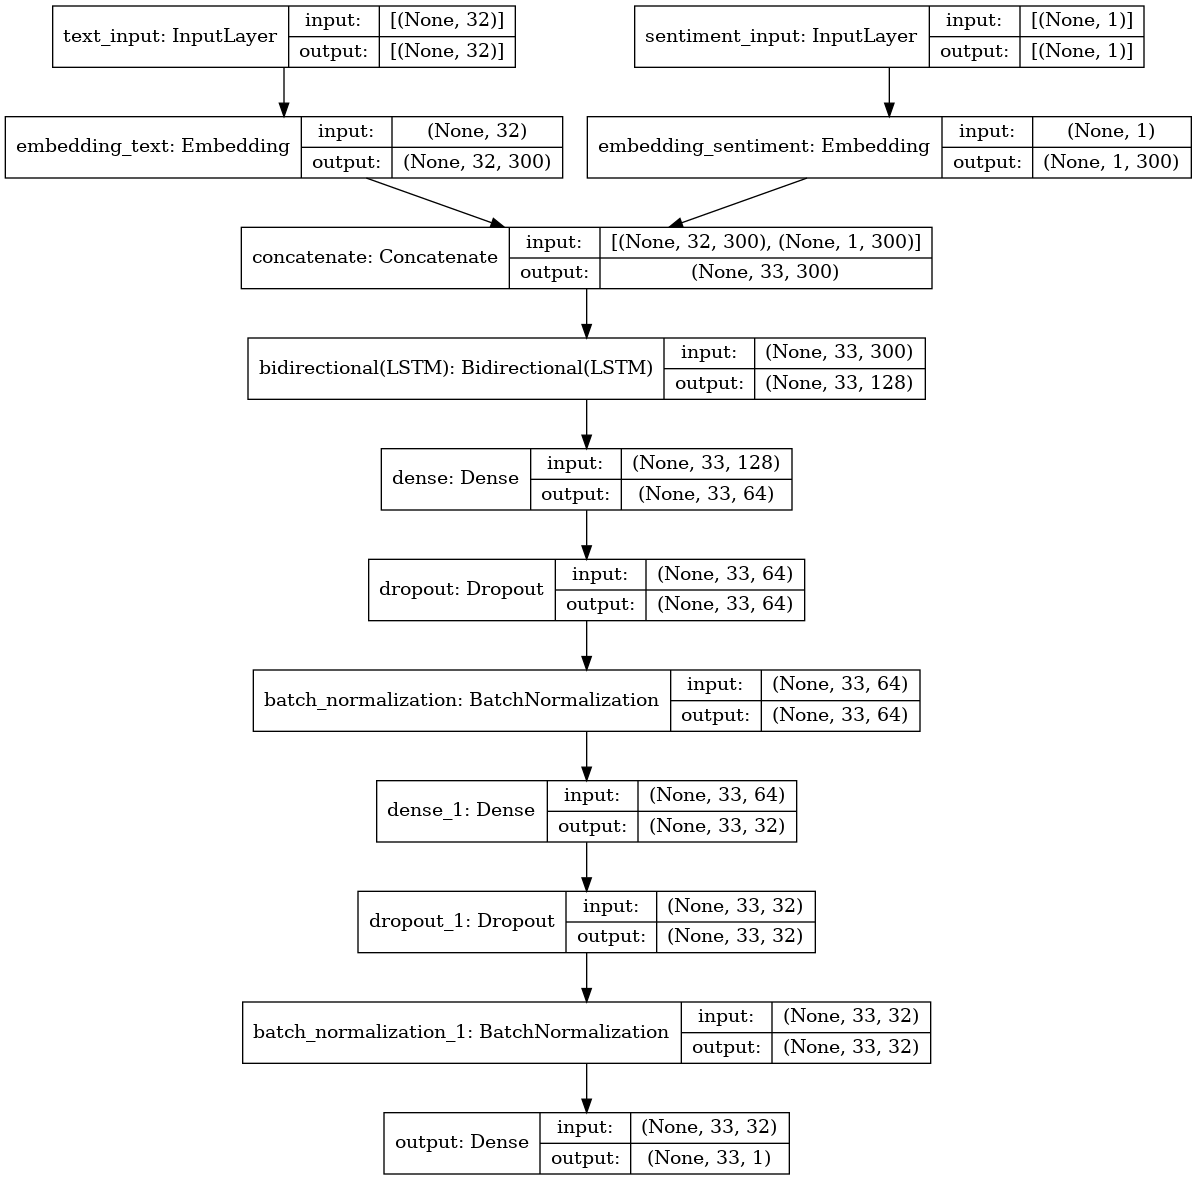

In [45]:
tf.keras.utils.plot_model(
    model, 'Model.png', show_shapes=True, show_layer_names=True)

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 32)]         0                                            
__________________________________________________________________________________________________
sentiment_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_text (Embedding)      (None, 32, 300)      7244400     text_input[0][0]                 
__________________________________________________________________________________________________
embedding_sentiment (Embedding) (None, 1, 300)       1200        sentiment_input[0][0]            
______________________________________________________________________________________________

#### Train model

In [47]:
log_dir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True)

checkpoint_filepath = 'LSTM_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, verbose=1)
adam = optimizers.Adam(0.001)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
callback = [model_checkpoint_callback, tensorboard]

history = model.fit([train_text, train_sentiment],
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=([valid_text, valid_sentiment], [y_valid]),
                    verbose=1,
                    callbacks=callback)

2021-11-09 11:08:24.711258: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-09 11:08:24.711592: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-09 11:08:24.716056: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-09 11:08:24.870676: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
  1/183 [..............................] - ETA: 48:17 - loss: 0.4711 - accuracy: 0.4955

2021-11-09 11:08:41.460016: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-09 11:08:41.460088: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/183 [..............................] - ETA: 3:10 - loss: 0.4496 - accuracy: 0.5062 

2021-11-09 11:08:41.968482: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-09 11:08:42.410491: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-09 11:08:42.879774: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20211109-110824/train/plugins/profile/2021_11_09_11_08_42

2021-11-09 11:08:43.007640: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20211109-110824/train/plugins/profile/2021_11_09_11_08_42/53fa0d774ded.trace.json.gz
2021-11-09 11:08:43.548216: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20211109-110824/train/plugins/profile/2021_11_09_11_08_42

2021-11-09 11:08:43.566135: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/20211109-110824/train/plugins/profile/2021_11_09_11_08_42/5

183/183 [==============================] - 100s 462ms/step - loss: 0.2161 - accuracy: 0.7704 - val_loss: 0.1709 - val_accuracy: 0.8153

Epoch 00001: val_loss improved from inf to 0.17093, saving model to LSTM_model.h5
Epoch 2/20
183/183 [==============================] - 79s 430ms/step - loss: 0.1748 - accuracy: 0.8280 - val_loss: 0.1626 - val_accuracy: 0.8314

Epoch 00002: val_loss improved from 0.17093 to 0.16256, saving model to LSTM_model.h5
Epoch 3/20
183/183 [==============================] - 80s 436ms/step - loss: 0.1683 - accuracy: 0.8353 - val_loss: 0.1566 - val_accuracy: 0.8332

Epoch 00003: val_loss improved from 0.16256 to 0.15660, saving model to LSTM_model.h5
Epoch 4/20
183/183 [==============================] - 78s 427ms/step - loss: 0.1630 - accuracy: 0.8380 - val_loss: 0.1543 - val_accuracy: 0.8331

Epoch 00004: val_loss improved from 0.15660 to 0.15432, saving model to LSTM_model.h5
Epoch 5/20
183/183 [==============================] - 79s 430ms/step - loss: 0.1602 - 

#### Visualisation

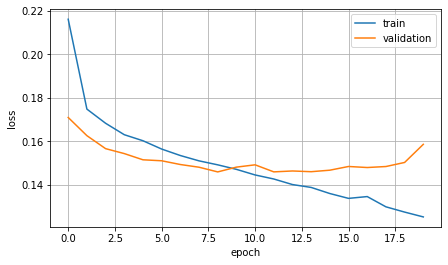

In [48]:
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

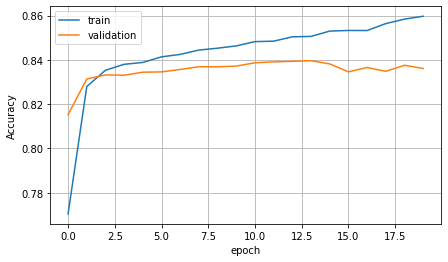

In [49]:
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

# 6. Prediction

In [50]:
train_pred = model.predict([train_text, train_sentiment])
train_pred = np.squeeze(train_pred)
train_pred = np.round(train_pred)
train_pred.shape

(23307, 33)

In [51]:
pred = []
for vector in train_pred:
    index = []
    for i, value in enumerate(vector):
        if value == 1:
            index.append(i)
    pred.append(np.array(index))
print(len(pred))

23307


In [52]:
X_train['prediction'] = pred
pred_text = X_train[['text', 'prediction']].apply(
    lambda x: get_text(x), axis=1)
X_train['pred_text'] = pred_text
X_train['pred_text'] = X_train['pred_text'].apply(lambda x: ' '.join(x))
X_train.head()

,textID,text,selected_text,sentiment,prediction,pred_text
20755,4adbe4614b,its my wall and i like saying i banned zac efr...,like,positive,"[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2...",
21055,51bcf89734,chillin at a bbq gettin my drink on,chillin,positive,"[0, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",chillin
6178,1466d41c7d,days whoop,days whoop,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",days whoop
25985,cf1d92928e,miss my hubby already,miss my hubby already,negative,"[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",miss
10883,b1f6dde209,nice have funalthough you cant not have fun lol,nice have funalthough you cant not have fun lol,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",nice have funalthough you cant not have fun lol


In [53]:
X_train['jaccard'] = X_train.apply(
    lambda x: jaccard(x.selected_text, x.pred_text), axis=1)
print('Mean training Jaccard score:', np.mean(X_train['jaccard']))
print("="*150)
print('nMean jaccard score for positive sentiment tweets:', np.mean(
    X_train[X_train['sentiment'] == 'positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets', np.mean(
    X_train[X_train['sentiment'] == 'negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets', np.mean(
    X_train[X_train['sentiment'] == 'neutral']['jaccard']))

Mean training Jaccard score: 0.6873423441723931
nMean jaccard score for positive sentiment tweets: 0.4945373407904073
Mean jaccard score for negative sentiment tweets 0.4776644518177985
Mean jaccard score for neutral sentiment tweets 0.9818246218883239


In [54]:
valid_pred = model.predict([valid_text, valid_sentiment])
valid_pred = np.squeeze(valid_pred)
valid_pred = np.round(valid_pred)
valid_pred.shape

(4113, 33)

In [55]:
pred = []
for vector in valid_pred:
    index = []
    for i, value in enumerate(vector):
        if value == 1:
            index.append(i)
    pred.append(np.array(index))
print(len(pred))

4113


In [56]:
X_valid['prediction'] = pred
pred_text = X_valid[['text', 'prediction']].apply(
    lambda x: get_text(x), axis=1)
X_valid['pred_text'] = pred_text
X_valid['pred_text'] = X_valid['pred_text'].apply(lambda x: ' '.join(x))
X_valid.head()

,textID,text,selected_text,sentiment,prediction,pred_text
6216,66bba7de03,thanks for pointing out the crucial problems ...,thanks for pointing out the crucial problems b...,positive,"[0, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24...",thanks of cc
8781,b5cee6e073,eleni i love you too,love,positive,"[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",eleni i love too
22310,8e6ba09a14,they shot him he was still alive too,they shot him he was still alive too,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",they shot him he was still alive too
10021,5652d8ae75,if i can get a ticket but the pickings are loo...,if i can get a ticket but the pickings are loo...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",if i can get a ticket but the pickings are loo...
24537,16a6c22866,mins from bej to semanggi traffic on friday ...,mins from bej to semanggi traffic on friday ...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",mins from bej to semanggi traffic on friday AB...


In [57]:
X_valid['jaccard'] = X_valid.apply(
    lambda x: jaccard(x.selected_text, x.pred_text), axis=1)
print('Mean training Jaccard score:', np.mean(X_valid['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:', np.mean(
    X_valid[X_valid['sentiment'] == 'positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets', np.mean(
    X_valid[X_valid['sentiment'] == 'negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets', np.mean(
    X_valid[X_valid['sentiment'] == 'neutral']['jaccard']))

Mean training Jaccard score: 0.634390798403982
Mean jaccard score for positive sentiment tweets: 0.4041959874586658
Mean jaccard score for negative sentiment tweets 0.39463774397509094
Mean jaccard score for neutral sentiment tweets 0.9841241412106358


# 7. Submission

In [58]:
model = load_model('LSTM_model.h5')
test_text = test['text'].values
test_sentiment = test['sentiment'].values
test_text = token1.texts_to_sequences(test_text)
test_text = sequence.pad_sequences(
    test_text, maxlen=max_len_text, padding='post')
test_sentiment = token2.texts_to_sequences(test_sentiment)
test_sentiment = sequence.pad_sequences(
    test_sentiment, maxlen=max_len_sentiment, padding='post')

test_pred = model.predict([test_text, test_sentiment])
test_pred = np.squeeze(test_pred)
test_pred = np.round(test_pred)
test_pred.shape

(3534, 33)

In [59]:
pred = []
for vector in test_pred:
    index = []
    for i, value in enumerate(vector):
        if value == 1:
            index.append(i)
    pred.append(np.array(index))
print(len(pred))

test['prediction'] = pred
pred_text = test[['text', 'prediction']].apply(lambda x: get_text(x), axis=1)
test['selected_text'] = pred_text
test['selected_text'] = test['selected_text'].apply(lambda x: ' '.join(x))
test.drop(['text', 'sentiment', 'prediction'], axis=1, inplace=True)
test.head()

3534


,textID,selected_text
0,f87dea47db,last session of the day
1,96d74cb729,also really china sh bj
2,eee518ae67,such a shame
3,01082688c6,happy bday
4,33987a8ee5,


In [60]:
test.to_csv("submission.csv", index=False)

# Conclusion
In this section we made Data prerocessing with Spellig analysis, used embeddings with GLOVE to create first layer in Model. Model was built on Bidirectional LSTM cells. Best result on BiLSTM - 0.44599/0.44985.